# analysis of altimetric data

In [1]:
import numpy as np
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt

import itide.tipe as tp

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


---

## setup cluster

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [3]:
from dask.distributed import Client
#client = Client() # with local cluster
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.1.99:58747 Dashboard: http://10.148.1.99:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## load data

In [5]:
#ds = xr.open_zarr('/home2/pharos/othr/aponte/alti/tp')
ds = (xr.open_zarr('/home/c11-data/Test_aponte/alti/tp')
       .chunk({'time': int(1e5)})
      ) 

# rechunking seems to help with the following problems:
# distributed.core - INFO - Event loop was unresponsive in Worker for 19.96s.  
# This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
# ...
# distributed.worker - ERROR - Worker stream died during communication: tcp:
# tornado.util.TimeoutError: Timeout
#
# is this related to a slow file system?

#ds = ds.isel(time=slice(0,int(157384325/4)))

print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
ds

Dataset size = 8.8 GB


<xarray.Dataset>
Dimensions:         (time: 157384325)
Coordinates:
    latitude        (time) float64 dask.array<chunksize=(100000,), meta=np.ndarray>
    longitude       (time) float64 dask.array<chunksize=(100000,), meta=np.ndarray>
  * time            (time) datetime64[ns] 1993-03-02T23:44:00.992296960 ... 2002-01-03T23:20:19.861993216
Data variables:
    cycle           (time) int16 dask.array<chunksize=(100000,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(100000,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    track           (time) int16 dask.array<chunksize=(100000,), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2019-02-20T16:19:50Z
    date_issued:                     2019-02-20T16:19:50Z
    date_modified:                   2019-02-20T16:19:50Z
    geospatial_lat_max:              66.144524
    geospatial_lat_min:              -66.147525
    geospatial_lat_resolution:       0.012951000000001045
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.99963299999996
    geospatial_lon_min:              0.013045999999999999
    geospatial_lon_resolution:       0.034414499999996906
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2019-02-20T16:19:50Z: Creation
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        Topex/Poseidon
    processing_level:                L3
    product_version:                 2019
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    software_version:                6.2_DUACS_DT2018_baseline
    source:                          Topex/Poseidon measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H5M7.505557S
    time_coverage_end:               1993-03-03T22:49:08Z
    time_coverage_resolution:        P1S
    time_coverage_start:             1993-03-02T23:44:00Z
    title:                           DT Topex/Poseidon Global Ocean Along tra...

In [6]:
print('start time: %s ' %str(ds.time[0].values))
print('end time:   %s ' %str(ds.time[-1].values))

start time: 1993-03-02T23:44:00.992296960 
end time:   2002-01-03T23:20:19.861993216 


---

<img src="altimetry_pic.png">

- SSH : Sea Surface Height
- MDT : Mean Dynamic Topography (temporal mean of the SSH above the Geoid over a period N)
- MSS : Mean Sea Surface (temporal mean of the SSH over a period N)
- SLA : Sea Level Anomaly deduced from the SSH using a MMS
- dac : Dynamic Atmospheric correction
- sla_filtered : Sea level anomaly
- sla_unfiltered : Sea level anomaly


---
## with [h3](https://github.com/uber/h3-py)

Python bindings for H3, a hierarchical hexagonal geospatial indexing system (see [here](https://uber.github.io/h3/))


Performance thread see [here](https://github.com/dask/dask/issues/4001)

In [14]:
client

Client Scheduler: tcp://10.148.1.99:58747 Dashboard: http://10.148.1.99:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Worker tcp://10.148.0.68:49811 restart in Job 7593769. This can be due to memory issue.


In [13]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out']
NoneType: None
distributed.client - ERROR - Restart timed out after 20.000000 seconds


Client Scheduler: tcp://10.148.1.99:58747 Dashboard: http://10.148.1.99:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [15]:
ddf = ds.to_dask_dataframe().persist() # persist may not be necessary anymore here

# will have to be deleted eventually (
ddf['longitude'] = (ddf['longitude']+180)%360 - 180
ddf = ddf[(ddf['longitude']<10)&(ddf['longitude']>-70)]
# )

Worker tcp://10.148.1.10:54155 restart in Job 7593768. This can be due to memory issue.


In [16]:
# find hex cell
resolution = 5 # 5: 250 km^2; 6: 36 km^2
ddf['hex_id'] = (ddf.apply(tp.get_hex, axis=1, 
                           args=(resolution,), meta='string') # use 'category' instead?
                )
# Could add .astype('category') but it will lead to weird behaviors: 
# all categories are tracked throughout comptutations even if some categories are filtered out
# https://docs.dask.org/en/latest/dataframe-categoricals.html

In [9]:
#ddf = ddf.persist()

In [10]:
#ddf['latitude'].mean().compute()

In [17]:
ddf = ddf.set_index('hex_id').persist() # setting hex_id as index will facilitate grouping by hex_id
ddf.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track
hex_id,,,,,,,,,,,
85060903fffffff,1993-10-03 13:53:37.817217536,65.949056,-34.412824,38,-0.0333,0.009,-0.254,-1.1729,0.114,0.115,219
85060903fffffff,1993-10-03 13:53:38.895797504,65.956040,-34.277868,38,-0.0340,0.009,-0.255,-1.1681,0.100,0.085,219
85060903fffffff,1993-09-05 20:43:24.725473024,65.829500,-34.392710,36,-0.0772,0.018,-0.264,1.0042,0.011,0.022,18
85060903fffffff,1993-10-05 14:38:59.229449728,65.829500,-34.392710,39,-0.1875,-0.002,-0.264,-0.9083,0.055,0.060,18
85060903fffffff,1993-08-26 22:44:52.915655936,65.829500,-34.392710,35,-0.0095,0.005,-0.264,-0.2928,-0.008,-0.014,18


## get basic statistics

In [18]:
df_stats = (ddf.drop(columns=['time'])[['sla_unfiltered']]
            .groupby('hex_id')
            .aggregate(['count', 'mean', 'std'])
           ).compute()

df_stats = tp.add_lonlat(df_stats, reset_index=True)
df_stats.head()

print('df_stats number of rows = %d '%len(df_stats.index))

df_stats number of rows = 53758 


In [19]:
df_stats

hex_id sla_unfiltered                            lat  \
                                count      mean       std              
0      85060903fffffff            224  0.042991  0.079260  65.905912   
1      85060907fffffff            172  0.043395  0.072245  65.747368   
2      8506090bfffffff            381  0.046932  0.079917  65.994495   
3      8506090ffffffff            297  0.040798  0.082487  65.835769   
4      85060913fffffff            413  0.045622  0.074034  65.975229   
...                ...            ...       ...       ...        ...   
53753  85eeebc7fffffff            384  0.018003  0.038395 -65.965741   
53754  85eeebcbfffffff            535  0.017626  0.039780 -66.031557   
53755  85eeebcffffffff            324  0.016599  0.037108 -65.918904   
53756  85eeebd7fffffff            749  0.016842  0.039722 -66.125804   
53757  85eeebdbfffffff            288  0.016358  0.040375 -66.192117   

             lon  
                  
0     -34.371550  
1     -34.400027  
2     -34.675244  
3     -34.701967  
4     -34.039865  
...          ...  
53753 -37.678722  
53754 -36.988204  
53755 -37.286444  
53756 -37.776885  
53757 -37.081973  

[53758 rows x 6 columns]

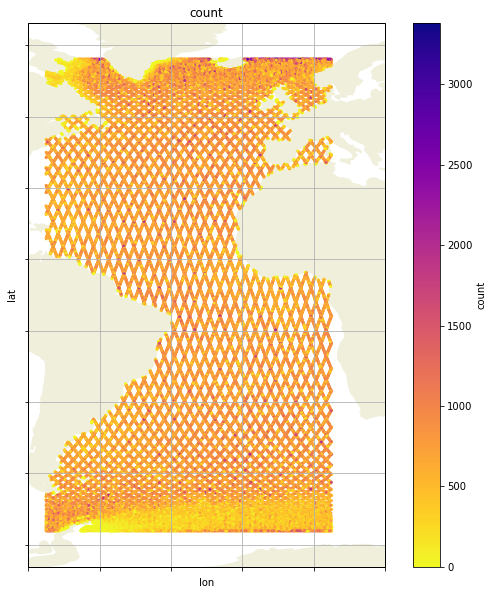

In [20]:
tp.plot_h3(df_stats, ['sla_unfiltered', 'count'])

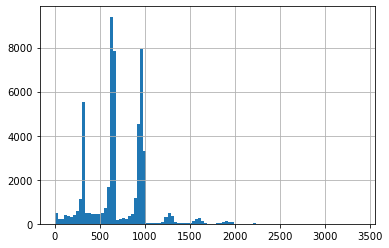

In [29]:
df_stats['sla_unfiltered']['count'].hist(bins=100)

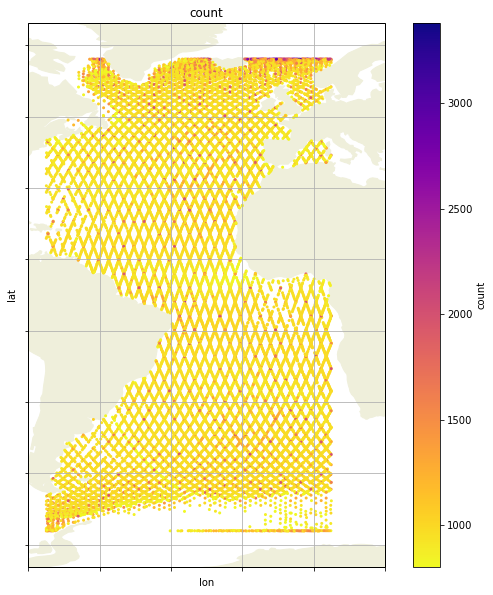

In [31]:
tp.plot_h3(df_stats[df_stats['sla_unfiltered']['count']>800], ['sla_unfiltered', 'count'])

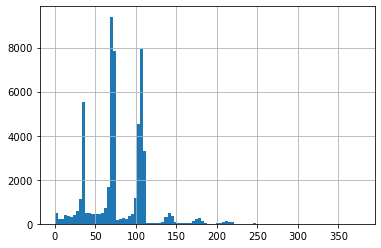

In [32]:
((df_stats['sla_unfiltered']['count'])/9).hist(bins=100)

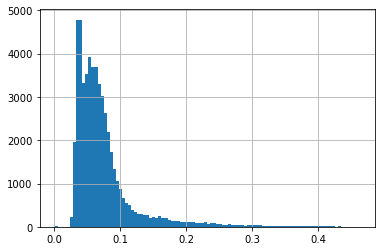

In [33]:
(df_stats['sla_unfiltered']['std']).hist(bins=100)

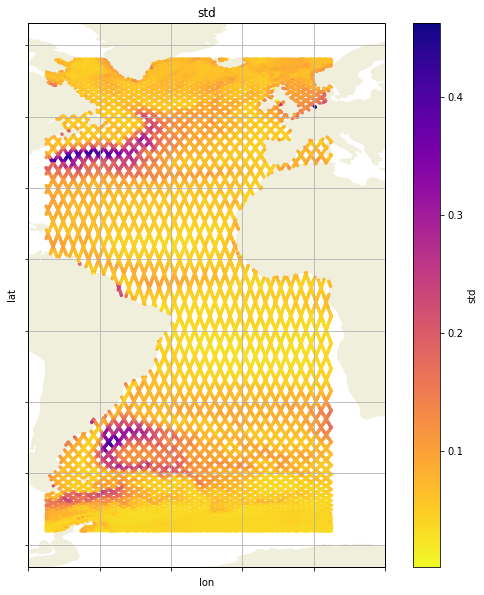

In [34]:
tp.plot_h3(df_stats, ['sla_unfiltered', 'std'])

## tidal analysis

In [35]:
cst = ['M2','S2']

In [50]:
df_har_1 = (ddf.groupby(['hex_id'])
          .apply(tp.harmonic_analysis, 
                 'ocean_tide', constituents=cst)
         ).compute()

df_har_1 = tp.add_lonlat(df_har_1.reset_index().drop(columns=['level_1']))

for c in cst:
    df_har_1[c+'_A'] = np.abs(df_har_1[c])
    df_har_1[c+'_phi'] = np.angle(df_har_1[c])*180./np.pi
    
df_har_1

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


,hex_id,M2,S2,lat,lon,M2_A,M2_phi,S2_A,S2_phi
0,85060903fffffff,-0.879156-0.205929j,-0.319334-0.284037j,65.905912,-34.371550,0.902951,-166.817019,0.427377,-138.347984
1,85060907fffffff,-0.891910-0.209560j,-0.267581-0.327246j,65.747368,-34.400027,0.916198,-166.777797,0.422716,-129.272027
2,8506090bfffffff,-0.904282-0.158689j,-0.309123-0.274174j,65.994495,-34.675244,0.918100,-170.046729,0.413193,-138.428810
3,8506090ffffffff,-0.890321-0.244890j,-0.284446-0.333050j,65.835769,-34.701967,0.923387,-164.620686,0.437986,-130.499409
4,85060913fffffff,-0.887590-0.162610j,-0.308523-0.278015j,65.975229,-34.039865,0.902363,-169.618296,0.415306,-137.977559
...,...,...,...,...,...,...,...,...,...
53753,85eeebc7fffffff,-0.188747-0.367692j,0.027448-0.293633j,-65.965741,-37.678722,0.413307,-117.172743,0.294913,-84.659618
53754,85eeebcbfffffff,-0.178714-0.364085j,-0.020094-0.286119j,-66.031557,-36.988204,0.405582,-116.144513,0.286824,-94.017289
53755,85eeebcffffffff,-0.203602-0.376212j,0.066564-0.334074j,-65.918904,-37.286444,0.427772,-118.421772,0.340641,-78.731357
53756,85eeebd7fffffff,-0.193187-0.371286j,0.007379-0.309622j,-66.125804,-37.776885,0.418538,-117.488859,0.309710,-88.634795


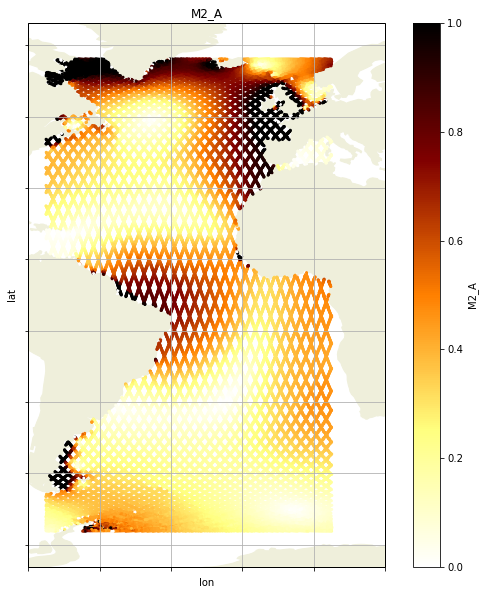

In [51]:
tp.plot_h3(df_har_1, 'M2_A', colormap='afmhot_r', vmax=1.)

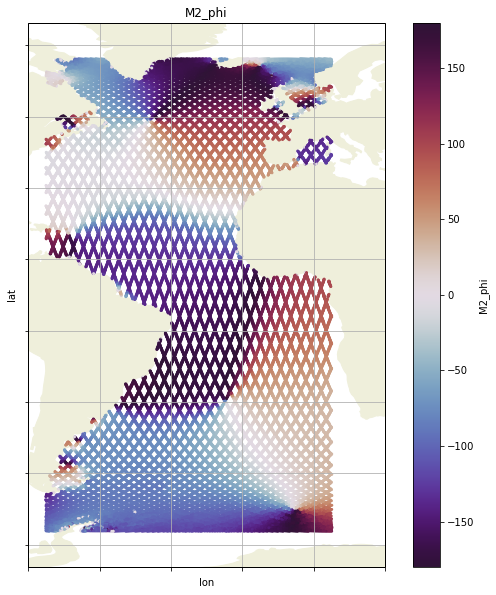

In [52]:
tp.plot_h3(df_har_1, 'M2_phi', colormap='twilight_shifted')

## what's next

- extraire les harmoniques de marée pour: sla_unfiltered+ocean_tide, sla_unfiltered

- calculer le niveau de bruit à partir de la formule analytique et afficher

- extraire les harmoniques de marée

In [40]:
ddf['sla_tide'] = ddf['sla_unfiltered'] + ddf['ocean_tide']
ddf

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track,sla_tide
npartitions=1574,,,,,,,,,,,,
85060903fffffff,datetime64[ns],float64,float64,int16,float32,float32,float32,float64,float32,float32,int16,float64
85060907fffffff,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
85eeebcbfffffff,...,...,...,...,...,...,...,...,...,...,...,...
85eeebdbfffffff,...,...,...,...,...,...,...,...,...,...,...,...


In [53]:
df_har_2 = (ddf.groupby(['hex_id'])
          .apply(tp.harmonic_analysis, 
                 'sla_unfiltered', constituents=cst)
         ).compute()

df_har_2 = tp.add_lonlat(df_har_2.reset_index().drop(columns=['level_1']))

for c in cst:
    df_har_2[c+'_A'] = np.abs(df_har_2[c])
    df_har_2[c+'_phi'] = np.angle(df_har_2[c])*180./np.pi
    
df_har_2

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


,hex_id,M2,S2,lat,lon,M2_A,M2_phi,S2_A,S2_phi
0,85060903fffffff,NaN,NaN,65.905912,-34.371550,NaN,NaN,NaN,NaN
1,85060907fffffff,0.008917-0.030751j,-0.001432-0.000311j,65.747368,-34.400027,0.032018,-73.830188,0.001465,-167.737745
2,8506090bfffffff,-0.012183+0.001748j,0.013280+0.012489j,65.994495,-34.675244,0.012308,171.836655,0.018231,43.242129
3,8506090ffffffff,0.016017+0.004493j,0.009050+0.015996j,65.835769,-34.701967,0.016635,15.671427,0.018378,60.499308
4,85060913fffffff,0.005463-0.007250j,-0.002079+0.002702j,65.975229,-34.039865,0.009078,-53.000877,0.003409,127.572614
...,...,...,...,...,...,...,...,...,...
53753,85eeebc7fffffff,0.004127-0.000671j,-0.000599+0.006838j,-65.965741,-37.678722,0.004181,-9.239143,0.006865,95.004549
53754,85eeebcbfffffff,0.000218-0.002352j,-0.000631+0.004598j,-66.031557,-36.988204,0.002362,-84.711308,0.004641,97.809358
53755,85eeebcffffffff,0.005767+0.002664j,-0.005247+0.002435j,-65.918904,-37.286444,0.006353,24.799137,0.005785,155.108462
53756,85eeebd7fffffff,0.005864-0.000021j,-0.000736+0.002456j,-66.125804,-37.776885,0.005864,-0.201596,0.002564,106.676977


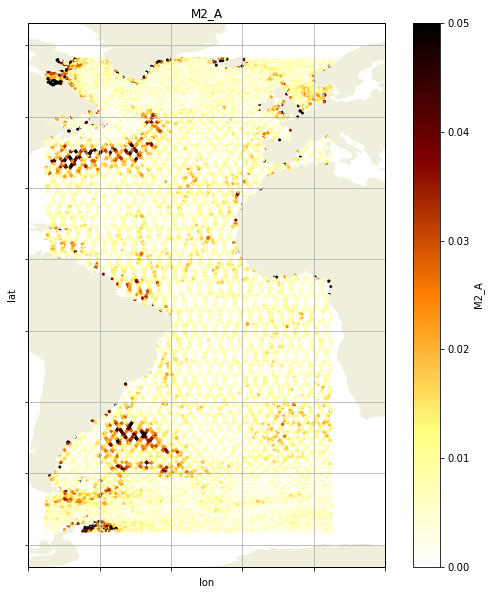

In [64]:
tp.plot_h3(df_har_2, 'M2_A', colormap='afmhot_r', vmax=.05)

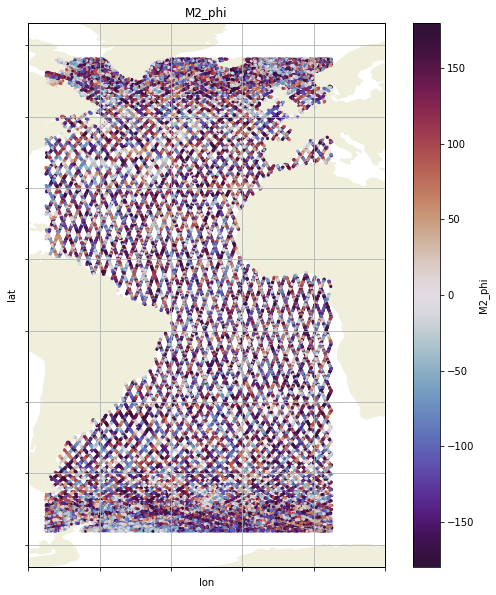

In [55]:
tp.plot_h3(df_har_2, 'M2_phi', colormap='twilight_shifted')

In [56]:
df_har_3 = (ddf.groupby(['hex_id'])
          .apply(tp.harmonic_analysis, 
                 'sla_tide', constituents=cst)
         ).compute()

df_har_3 = tp.add_lonlat(df_har_3.reset_index().drop(columns=['level_1']))

for c in cst:
    df_har_3[c+'_A'] = np.abs(df_har_3[c])
    df_har_3[c+'_phi'] = np.angle(df_har_3[c])*180./np.pi
    
df_har_3

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


,hex_id,M2,S2,lat,lon,M2_A,M2_phi,S2_A,S2_phi
0,85060903fffffff,NaN,NaN,65.905912,-34.371550,NaN,NaN,NaN,NaN
1,85060907fffffff,-0.882994-0.240312j,-0.269012-0.327557j,65.747368,-34.400027,0.915111,-164.775375,0.423865,-129.395220
2,8506090bfffffff,-0.916465-0.156941j,-0.295843-0.261685j,65.994495,-34.675244,0.929806,-170.282565,0.394971,-138.505923
3,8506090ffffffff,-0.874304-0.240396j,-0.275396-0.317055j,65.835769,-34.701967,0.906752,-164.626045,0.419960,-130.977790
4,85060913fffffff,-0.882127-0.169860j,-0.310602-0.275313j,65.975229,-34.039865,0.898332,-169.100678,0.415055,-138.446749
...,...,...,...,...,...,...,...,...,...
53753,85eeebc7fffffff,-0.184620-0.368363j,0.026849-0.286795j,-65.965741,-37.678722,0.412039,-116.619543,0.288049,-84.651615
53754,85eeebcbfffffff,-0.178496-0.366437j,-0.020725-0.281521j,-66.031557,-36.988204,0.407599,-115.971329,0.282283,-94.210360
53755,85eeebcffffffff,-0.197835-0.373547j,0.061317-0.331639j,-65.918904,-37.286444,0.422701,-117.906221,0.337260,-79.524809
53756,85eeebd7fffffff,-0.187323-0.371306j,0.006643-0.307166j,-66.125804,-37.776885,0.415883,-116.770833,0.307238,-88.761037


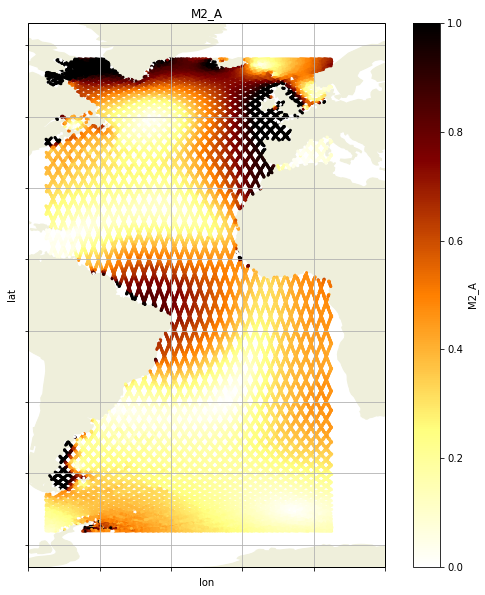

In [57]:
tp.plot_h3(df_har_3, 'M2_A', colormap='afmhot_r', vmax=1.)

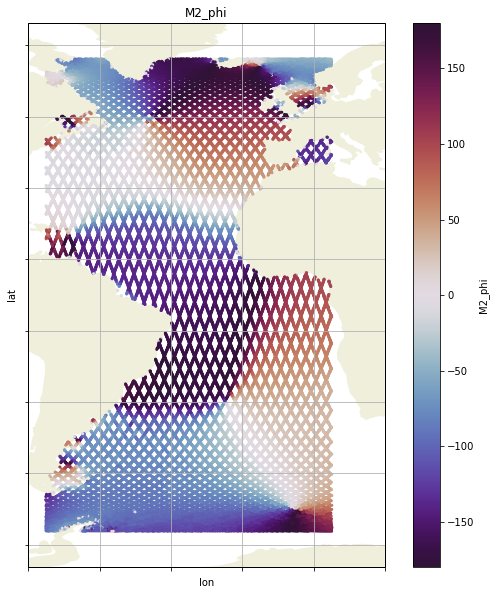

In [58]:
tp.plot_h3(df_har_3, 'M2_phi', colormap='twilight_shifted')

In [74]:
noise=df_stats['sla_unfiltered']['std']
N=df_stats['sla_unfiltered']['count']

df_stats['ecart_type']=1.5*noise/np.sqrt(N)

In [75]:
df_stats

hex_id sla_unfiltered                            lat  \
                                count      mean       std              
0      85060903fffffff            224  0.042991  0.079260  65.905912   
1      85060907fffffff            172  0.043395  0.072245  65.747368   
2      8506090bfffffff            381  0.046932  0.079917  65.994495   
3      8506090ffffffff            297  0.040798  0.082487  65.835769   
4      85060913fffffff            413  0.045622  0.074034  65.975229   
...                ...            ...       ...       ...        ...   
53753  85eeebc7fffffff            384  0.018003  0.038395 -65.965741   
53754  85eeebcbfffffff            535  0.017626  0.039780 -66.031557   
53755  85eeebcffffffff            324  0.016599  0.037108 -65.918904   
53756  85eeebd7fffffff            749  0.016842  0.039722 -66.125804   
53757  85eeebdbfffffff            288  0.016358  0.040375 -66.192117   

             lon ecart_type  
                             
0     -34.371550   0.007944  
1     -34.400027   0.008263  
2     -34.675244   0.006141  
3     -34.701967   0.007180  
4     -34.039865   0.005464  
...          ...        ...  
53753 -37.678722   0.002939  
53754 -36.988204   0.002580  
53755 -37.286444   0.003092  
53756 -37.776885   0.002177  
53757 -37.081973   0.003569  

[53758 rows x 7 columns]

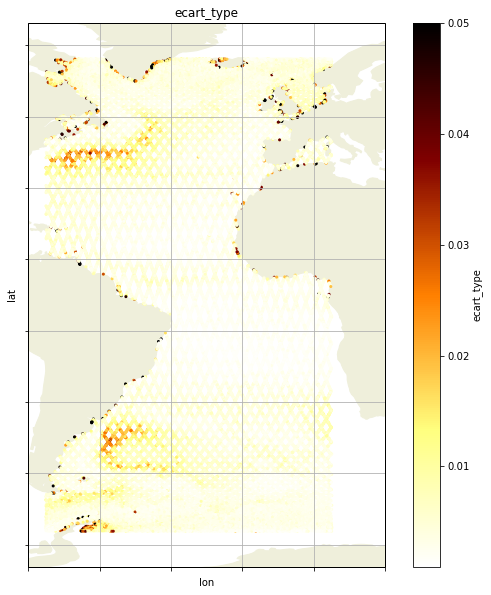

In [76]:
tp.plot_h3(df_stats, 'ecart_type', colormap='afmhot_r', vmax=.05)

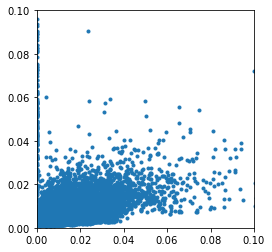

In [88]:
ax = plt.subplot(1,1,1)
ax.plot(df_har_2['M2_A'], df_stats['ecart_type'], '.')
ax.set_xlim((0,.1))
ax.set_ylim((0,.1))
ax.set_aspect(1)

---

In [82]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1283, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1012, in _reconnect
    await self._close()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/cli